In [16]:
def linear_newmark_krenk(M,C,K,f,u0,udot0,h,gamma,beta):
    """
    Return the solution of a system of second order differential equations obtained by Newmarks beta method  
    
    Arguments
    ---------------------------
    M : double
         Mass matrix
    C : double
         Damping matrix
    K : double
         Stiffness matrix
    f : double
         Load vectors
    u0 : double
         initial displacements
    udot0 : double
         initial velocity
    h : double
         time step size
    gamma : double
         parameter in the algorithm
    beta  : double
         parameter in the algorithm
         
        
    Returns
    ---------------------------
    u : double
        displacements
    udot : double
        velocities
    u2dot : double
        accelerations
        
    Reference: 
    Krenk, S. (2009). Non-linear modeling and analysis of solids and structures. Cambridge University Press.   
        
    """
    
    # Initialize variables
    u = np.zeros((M.shape[0],f.shape[1]))
    
    udot = np.zeros((M.shape[0],f.shape[1]))
    
    u2dot = np.zeros((M.shape[0],f.shape[1]))
    
    # Insert initial conditions in response vectors
    u[:,0] = u0[:,0]
    
    udot[:,0] = udot0[:,0]
    
    # Calculate "modified mass"
    Mstar = M + gamma*h*C + beta*h**2*K;
    
    # Calculate initial accelerations
    u2dot[:,0] = np.linalg.solve(M, f[:,0]-np.dot(C,udot[:,0])-np.dot(K,u[:,0])) 
    
    for n in range(0,f.shape[1]-1):
        
        #Predicion step
        
        udotstar_np1 = udot[:,n] + (1-gamma)*h*u2dot[:,n];
        
        ustar_np1 = u[:,n] + h*udot[:,n] + (1/2-beta)*h**2*u2dot[:,n];
        
        # Correction step
        
        u2dot[:,n+1] = np.linalg.solve(M, f[:,n+1]-np.dot(C,udotstar_np1)-np.dot(K,ustar_np1)) 
        
        udot[:,n+1] = udotstar_np1 + gamma*h*u2dot[:,n+1];
        
        u[:,n+1] = ustar_np1 + beta*h**2*u2dot[:,n+1];
    
    return u, udot, u2dot





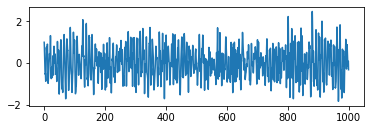

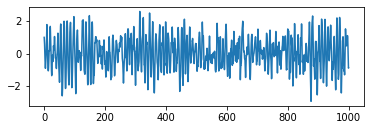

In [17]:
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt


M = np.array(([1.0, 0.0], [0.0, 1.0]))
K = np.array(([2, -1],[-1, 1]))
C = np.array(([0.1, 0],[0, 0.1]))
eig,eigv = spla.eig(K,M)

u0 = np.array(([1],[1]))
udot0 = np.array(([0],[0]))

t = np.array(([np.linspace(0,1000,10000)]))
f = np.zeros((2,t.shape[1]))

h = t[0,1]-t[0,0]
fl = 1.62/2/np.pi

gamma = 1.0/2.0
beta = 1.0/4.0

f[0,:] = np.random.normal(0, 1, t.shape[1])
f[1,:] = np.random.normal(0, 1, t.shape[1])

u,udot,u2dot = linear_newmark_krenk(M,C,K,f,u0,udot0,h,gamma,beta)
    
plt.figure()
plt.subplot(2,1,1)
plt.plot(t[0,:],u[0,:])
plt.show()
plt.subplot(2,1,2)
plt.plot(t[0,:],u[1,:])
plt.show()
                                   

### Step 1.
Establish the block hankel matrix and split it into past and future

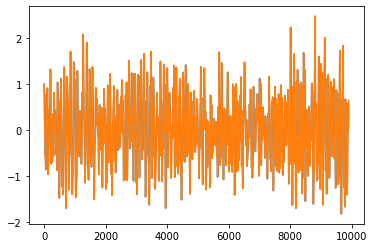

In [18]:
s = 50   # 2s is the number of block rows

y = u

M = y.shape[0] # Number of channels
N = y.shape[1] # Number of sampling points

Yh = np.zeros((2*s*M,N-2*s+1)) # Initialize the Block Hankel matrix

for k in range(0,2*s):
    Yh[k*M:(k+1)*M,:] = y[:,k:N-2*s+k+1]  # Block Hankel matrix

#Yhf = np.zeros((s*M,N-2*s)) # Initialize the Block Hankel matrix
    
Yhp = Yh[0:s*M,:]
Yhf = Yh[s*M:N-2*s,:]
    
# Plot two time shifted time series for comparison
m = 1;
plt.figure()
plt.plot(Yh[0,:])
plt.plot(Yh[2*m,:])

### Step 2.
Projection of the future onto the past

In [57]:
O = np.matmul(Yhf,np.matmul(Yhp.T,np.linalg.solve(np.matmul(Yhp,Yhp.T),Yhp))) 

### Step 3
Sinular value decomposition


In [20]:
U, S_vector, Vh = np.linalg.svd(O, full_matrices=True) #Singular value decomposition

### Step 4
Obtain system matrices for different orders

In [58]:
dt = h

orders = list(range(4,100)) # Orders that will be considered

omega_mat = np.zeros([len(orders),np.max(orders)])
zeta_mat = np.zeros([len(orders),np.max(orders)])
kk = 0
for order in orders:
    S_selected = np.zeros((order,order)) # Matrix of selected singular values
    np.fill_diagonal(S_selected,S_vector[0:order])
    U_selected = U[:,0:order] 
    Vh_selected = U[0:order,:]

    That = np.matmul(U_selected,(S_selected**0.5))
    X0 = np.matmul((S_selected**0.5),Vh_selected)

    C = That[0:M,:] # Observation matrix

    Ad = np.matmul(np.linalg.pinv(That[M:2*s,:]),That[0:2*s-M,:] )

    mu,psi = np.linalg.eig(Ad)

    lam = np.array([np.log(mu)/dt])
    omega = np.array(abs(lam))
    omega_u, pos = np.unique([omega],return_index=True)
    omega_u = np.array([omega_u])
    psi_u = psi[:,pos]
    lam_u = lam[:,pos]
    omega_mat[kk,0:omega_u.shape[1]] =  omega_u 
    zeta_mat[kk,0:omega_u.shape[1]] =  -lam_u.real/np.abs(lam_u)
    kk = kk + 1
    

### Step 5
Make stabilization diagram

Text(0.5, 0, 'Frequency (hz)')

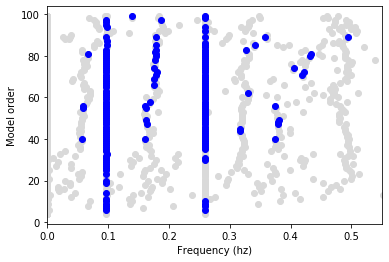

In [56]:
Diff_omega = np.diff(omega_mat,axis=0)/(omega_mat[1:omega_mat.shape[0],:]+1.0e-3)*100 # Precentage difference in frequency from one order to the next
Diff_zeta = np.diff(zeta_mat,axis=0)/(zeta_mat[1:zeta_mat.shape[0],:]+1.0e-3)*100 # Precentage difference in damping ratio from one order to the next

Stab = np.ones((omega_mat.shape[0]-1,omega_mat.shape[1])) # Matrix that indecate if the pole is stable or not
Stab[np.abs(Diff_omega)>1] = 0  # If the frequency varies more then 1%, it is considered as unstable                          
Stab[np.abs(Diff_zeta)>5] = 0   # If the damping ratio varies more then 5 %, the pole is conisdered unstable

omega_mat_plot = np.copy(omega_mat[1:,:])
omega_mat_plot[Stab == 0] = np.nan # Set the frequency to NaN if the pole is unstable
omega_mat_plot[omega_mat_plot==0] = np.nan # Set the frequency to NaN if the frequency is zero (This is not a frequency, but unused locations in the matrix)

plt.figure()
plt.plot(omega_mat/2/np.pi,orders,'o',C='0.85')
plt.plot(omega_mat_plot/2/np.pi,orders[1:len(orders)],'bo')
plt.xlim([0, 0.55])
plt.ylabel('Model order')
plt.xlabel('Frequency (hz)')